In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import shutil
import numpy as np
from scipy import stats
from tqdm import tqdm
from IPython.display import clear_output
import re

import py21cmfish
from py21cmfish.power_spectra import *
from py21cmfish.io import *

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

from scripts.step_size import *

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:43: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Default cache dir: /n/netscratch/iaifi_lab/Lab/yitians/dm21cm/21cmFAST-cache


In [2]:
noise_dir = "/n/home07/yitians/dm21cm/21cmSense_fid_EOS21/"
outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"
# outputs_dir = "/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/paper1"

## 1. 21cmFISH standard astrophysics

In [3]:
bkg_dir = f"{outputs_dir}/bkg/"

astro_params_vary = ['DM', 'F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI', 't_STAR',
                     'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH', 'A_LW']
default_param_values = [0, -1.25, -2.5, 0.5, 0.0, 0.5, -1.35, -1.35, -0.3, 40.5, 40.5, 500, 2.0]

astro_params_fid = dict()
for i, ap in enumerate(astro_params_vary):
    astro_params_fid[ap] = default_param_values[i]

# Load each parameter into a dictionary
params_EoS = {}
for param in astro_params_vary[1:]:
    params_EoS[param] = py21cmfish.Parameter(
        HII_DIM=128, BOX_LEN=256, param=param,
        output_dir = bkg_dir,
        PS_err_dir = noise_dir,
        new = False
)
clear_output()

## 2. Fisher analysis at each mass

In [ ]:
! ls $outputs_dir/bkg -lt

In [4]:
run_name = 'pbhacc-PRc23-250808'
channel = run_name.rsplit('-', 1)[0]
inj_dir = f"{outputs_dir}/active/{run_name}"
print(os.listdir(inj_dir))

# Get the simulated masses of the injected signal
log10m_s = np.sort([
    float(re.match(r'log10m([-\d\.]+)', d).group(1))
    for d in os.listdir(inj_dir)
    if re.match(r'log10m([-\d\.]+)', d)
])
# log10m_s = np.sort(log10m_s)
m_s = 10**log10m_s
print('log10m_s', log10m_s)

EPSILON = 1e-6

if channel == 'decay-phot':
    tau_s = decay_phot_lifetime(m_s)
    inj_s = 1/tau_s
elif channel == 'decay-elec':
    tau_s = decay_elec_lifetime(m_s)
    inj_s = 1/tau_s
elif channel.startswith('pwave-phot'):
    c_s = pwave_phot_c_sigma(m_s)
    inj_s = c_s
elif channel == 'pwave-elec':
    c_s = pwave_elec_c_sigma(m_s)
    inj_s = c_s
elif channel == 'pwave-tau':
    c_s = pwave_tau_c_sigma(m_s)
    inj_s = c_s
elif channel.startswith('pbhhr'):
    a_PBH = float(channel.split('-')[1][1:])
    f_s = pbhhr_f(m_s, a=a_PBH)
    inj_s = f_s
elif channel.startswith('pbhacc'):
    model = channel.split('-')[1]
    f_s = pbhacc_f(m_s, model)
    inj_s = f_s

# Copy the fiducial lightcone in each mass directory
print('Copied :', end=' ')
for m in m_s:
    source_file = f'{bkg_dir}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    target_file = f'{inj_dir}/log10m{np.log10(m):.3f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    if not os.path.isfile(target_file):
        print(f'{np.log10(m):.3f}', end=' ')
        shutil.copyfile(source_file, target_file)

['log10m3.000', 'log10m0.000', 'log10m2.500', 'log10m1.000', 'log10m1.500', 'log10m2.000', 'log10m4.000', 'log10m3.500', 'log10m0.500']
log10m_s [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
Copied : 

In [5]:
sigma_s = []
force_new = False

for m in tqdm(m_s):

    lc_dir = f'{inj_dir}/log10m{np.log10(m):.3f}/'
    new = ('lc_redshifts.npy' not in os.listdir(lc_dir)) or force_new
    
    for param in astro_params_vary[:1]:
        params_EoS[param] = py21cmfish.Parameter(
            HII_DIM=128, BOX_LEN=256, param=param,
            output_dir=lc_dir,
            PS_err_dir=noise_dir, new=new,
        )

    Fij_matrix_PS, Finv_PS = py21cmfish.make_fisher_matrix(
        params_EoS,
        fisher_params=astro_params_vary,
        hpeak=0.0, obs='PS',
        k_min=0.1, k_max=1,
        sigma_mod_frac=0.2,
        add_sigma_poisson=True
    )
    sigma_s.append(np.sqrt(Finv_PS[0, 0]))
    
sigma_s = np.array(sigma_s)
print('sigma', sigma_s)

  0%|          | 0/9 [00:00<?, ?it/s]

########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded PS from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.000/power_spectrum_dict_DM.npy
    Loaded fiducial PS from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.000/power_spectrum_fid_21cmsense.npy, shape:(23, 46)
    Loading 21cmsense errors from /n/home07/yitians/dm21cm/21cmSense_fid_EOS21/


 11%|█         | 1/9 [00:00<00:07,  1.14it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.500/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.500/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 22%|██▏       | 2/9 [00:01<00:05,  1.19it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.500/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.500/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m0.500/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 33%|███▎      | 3/9 [00:02<00:05,  1.17it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.500/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.500/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 44%|████▍     | 4/9 [00:03<00:04,  1.18it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.500/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.500/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m1.500/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 56%|█████▌    | 5/9 [00:04<00:03,  1.16it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.500/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.500/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 67%|██████▋   | 6/9 [00:05<00:02,  1.17it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.500/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.500/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m2.500/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 78%|███████▊  | 7/9 [00:05<00:01,  1.18it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.500/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.500/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

 89%|████████▉ | 8/9 [00:06<00:00,  1.20it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.500/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.500/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m3.500/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
########### fisher set up for DM
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m4.000/global_signal_dict_DM.npy
    Loaded param values from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m4.000/params_dict_DM.npy
    Loading global signal and power spectra from saved files
    Loaded P

100%|██████████| 9/9 [00:07<00:00,  1.19it/s]

    Loaded PS_z_HERA from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m4.000/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m4.000/global_signal_deriv_dict_DM.npy
    Loaded PS derivatives from /n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/active/pbhacc-PRc23-250808/log10m4.000/power_spectrum_deriv_dict_DM.npy shape= (69, 46)
    Loading Poisson noise for PS
    Fiducial: DM=1
PS shape: (23, 24)
sigma [ 81.84990364  82.80249601  77.17168904  78.70129664  80.64351173
  80.36003933  96.03271329 103.13668439 105.65263507]


In [8]:
# check sigma as a multiple of step size. recommended: 30-100
sigma_s

array([ 81.84990364,  82.80249601,  77.17168904,  78.70129664,
        80.64351173,  80.36003933,  96.03271329, 103.13668439,
       105.65263507])

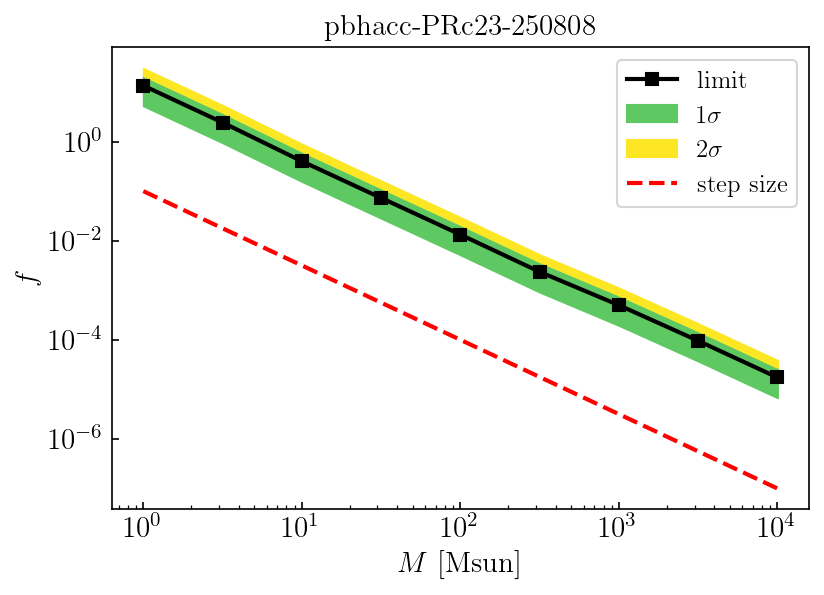

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

one_sigma = inj_s * sigma_s
upper_limit = np.sqrt(stats.chi2.ppf(.9, df=1)) * one_sigma

ax.plot(m_s, upper_limit, 'k-s', label='limit')
ax.fill_between(m_s, upper_limit + one_sigma, upper_limit - one_sigma, color=mpl.colormaps['viridis'](0.75), label='1$\sigma$')
ax.fill_between(m_s, upper_limit + 2*one_sigma, upper_limit + one_sigma, color=mpl.colormaps['viridis'](1.0), label='2$\sigma$')

ax.set(xscale='log', yscale='log')
ax.set(title=run_name)

m_fine_s = np.geomspace(m_s[0], m_s[-1], 100)
if channel == 'decay-phot':
    ax.plot(m_fine_s, 1/decay_phot_lifetime(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$1/\tau$ [s$^{-1}$]')
elif channel == 'decay-elec':
    ax.plot(m_fine_s, 1/decay_elec_lifetime(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$1/\tau$ [s$^{-1}$]')
elif channel == 'pwave-phot':
    ax.plot(m_fine_s, pwave_phot_c_sigma(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$C_\sigma$ [cm$^3$/s]')
elif channel == 'pwave-elec':
    ax.plot(m_fine_s, pwave_elec_c_sigma(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$C_\sigma$ [cm$^3$/s]')
elif channel == 'pwave-tau':
    ax.plot(m_fine_s, pwave_tau_c_sigma(m_fine_s), 'r--', label='step size')
    ax.set(xlabel=r'$m_\chi$ [eV]', ylabel=r'$C_\sigma$ [cm$^3$/s]')
elif channel.startswith('pbhhr'):
    ax.plot(m_fine_s, pbhhr_f(m_fine_s, a=a_PBH), 'r--', label='step size')
    ax.set(xlabel=r'$M$ [g]', ylabel=r'$f$')
elif channel.startswith('pbhacc'):
    ax.plot(m_fine_s, pbhacc_f(m_fine_s, model), 'r--', label='step size')
    # log10f = -0.3 * log10m - 10.75
    # ax.plot(m_fine_s, 10**(-0.1 * np.log10(m_fine_s) - 10.5), 'g:', label='step size')
    ax.set(xlabel=r'$M$ [Msun]', ylabel=r'$f$')
ax.legend()

In [9]:
save_fn = f'../outputs/limits/{run_name}.txt'
dir_path = os.path.dirname(save_fn)
os.makedirs(dir_path, exist_ok=True)
np.savetxt(save_fn, np.array([m_s, inj_s, sigma_s]).T, header='mass_s inj_s sigma_s')

# Corner

In [4]:
run_name = 'decay-elec'
channel = 'decay-elec'
inj_dir = f"/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/decay/elec"
print(os.listdir(inj_dir))

# Get the simulated masses of the injected signal
log10m_s = np.sort([
    float(re.match(r'log10m([-\d\.]+)', d).group(1))
    for d in os.listdir(inj_dir)
    if re.match(r'log10m([-\d\.]+)', d)
])
# log10m_s = np.sort(log10m_s)
m_s = 10**log10m_s
print('log10m_s', log10m_s)

EPSILON = 1e-6

if channel == 'decay-phot':
    tau_s = decay_phot_lifetime(m_s)
    inj_s = 1/tau_s
elif channel == 'decay-elec':
    tau_s = decay_elec_lifetime(m_s)
    inj_s = 1/tau_s

['log10m9.250', 'log10m10.750', 'log10m7.250', 'log10m6.500', 'log10m11.500', 'log10m7.500', 'log10m7.750', 'log10m9.750', 'log10m9.000', 'log10m11.250', 'log10m6.750', 'log10m11.750', 'log10m10.250', 'log10m9.500', 'log10m12.000', 'log10m10.000', 'log10m8.250', 'log10m10.500', 'log10m8.750', 'log10m8.500', 'log10m8.000', 'log10m7.000', 'log10m11.000']
log10m_s [ 6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75  9.    9.25
  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75 12.  ]


In [ ]:
force_new = False

m = 1e8

lc_dir = f'{inj_dir}/log10m{np.log10(m):.3f}/'
new = ('lc_redshifts.npy' not in os.listdir(lc_dir)) or force_new

for param in astro_params_vary[:1]:
    params_EoS[param] = py21cmfish.Parameter(
        HII_DIM=128, BOX_LEN=256, param=param,
        output_dir=lc_dir,
        PS_err_dir=noise_dir, new=new,
    )

Fij_matrix_PS, Finv_PS = py21cmfish.make_fisher_matrix(
    params_EoS,
    fisher_params=astro_params_vary,
    hpeak=0.0, obs='PS',
    k_min=0.1, k_max=1,
    sigma_mod_frac=0.2,
    add_sigma_poisson=True
)
sigma = np.sqrt(Finv_PS[0, 0])

print('sigma', sigma)

if channel == 'decay-phot':
    tau = decay_phot_lifetime(m)
    inj = 1/tau
elif channel == 'decay-elec':
    tau = decay_elec_lifetime(m)
    inj = 1/tau

print('inj', inj)

In [30]:
inj_base = 1e-29
ratio = inj / inj_base
label_DM = r'$\frac{\Gamma}{10^{-29}s^{-1}}$'

In [31]:
F_mat = Fij_matrix_PS.copy()
F_mat[:, 0] /= ratio
F_mat[0, :] /= ratio
F_inv = np.linalg.inv(F_mat)

In [32]:
fid_params = np.array([astro_params_fid[param] for param in astro_params_vary])
label_d = py21cmfish.astro_params_labels
label_d['L_X'] = '$\\log_{10}\\frac{L^{II}_X/{\\dot{M}_\\star}}{\\mathrm{erg}\\,\\mathrm{s}^{-1}\\, M_\\odot^{-1}\\,\\mathrm{yr}}$'
label_d['L_X_MINI'] = '$\\log_{10}\\frac{L^{III}_X/{\\dot{M}_\\star}}{\\mathrm{erg}\\,\\mathrm{s}^{-1}\\, M_\\odot^{-1}\\,\\mathrm{yr}}$'
label_d['DM'] = label_DM # \Gamma / inj_s
fid_labels = np.array([label_d[param] for param in astro_params_vary])

In [33]:
def plot_triangle(params, fiducial, cov, fig=None, ax=None,
                   positive_definite=[],
                   labels=None,
                   resize_lims=True,
                   N_std=[1.,2.], plot_rescale = 4.,
                   ellipse_color='tab:blue',
                   ellipse_kwargs=[{},
                                  {'alpha':0.5}],
                   title_fontsize=20,
                   xlabel_kwargs={'labelpad': 5, 'fontsize':18},
                   ylabel_kwargs={'labelpad': 5, 'fontsize':18},
                   fig_kwargs={'figsize': (8, 8)},
                   plot1D_kwargs={'c':'black', 'lw':1}):
    """
    Make a triangle plot from a covariance matrix

    Based on https://github.com/xzackli/fishchips-public/blob/master/fishchips/util.py

    Parameters
    ----------
        params : list of strings
            List of parameter strings

        fiducial : array
            Numpy array consisting of where the centers of ellipses should be

        cov : numpy array
            Covariance matrix to plot

        fig : optional, matplotlib figure
            Pass this if you already have a figure

        ax : array containing matplotlib axes
            Pass this if you already have a set of matplotlib axes

        positive_definite: list
            List of parameter strings which are positive definite

        resize_lims : bool
            Resize ellipse limits to scale of the errors [default = True]

        N_std : list
            List of number of standard deviations to plot

        labels : list
            List of labels corresponding to each dimension of the covariance matrix

        ellipse_kwargs : dict
            Keyword arguments for passing to the 1-sigma Matplotlib Ellipse call. You
            can change this to change the color of your ellipses, for example.

        xlabel_kwargs : dict
            Keyword arguments which are passed to `ax.set_xlabel()`. You can change the
            color and font-size of the x-labels, for example. By default, it includes
            a little bit of label padding.

        ylabel_kwargs : dict
            Keyword arguments which are passed to `ax.set_ylabel()`. You can change the
            color and font-size of the y-labels, for example. By default, it includes
            a little bit of label padding.

        fig_kwargs : dict
            Keyword arguments which are passed to `figure`. E.g. figsize

        plot1D_kwargs : dict
            Keyword arguments which are passed to `plt.plot()` for 1D gauss plot

    Returns
    -------
        fig, ax
            matplotlib figure and axis array
    """

    nparams = len(params)

    if ax is None or fig is None:
        print('generating new axis')
        fig, ax = plt.subplots(nparams, nparams, **fig_kwargs)

    if labels is None:
        labels = [(r'$\mathrm{' + p.replace('_', r'\_') + r'}$')
                  for p in params]

    # stitch together axes to row=nparams-1 and col=0
    # and turn off non-edge
    for ii in range(nparams):
        for jj in range(nparams):
            if ii == jj:
                ax[jj, ii].get_yaxis().set_visible(False)
                if ii < nparams-1:
                    ax[jj, ii].get_xaxis().set_ticks([])

            if ax[jj, ii] is not None:
                if ii < jj:
                    if jj < nparams-1:
                        ax[jj, ii].set_xticklabels([])
                    if ii > 0:
                        ax[jj, ii].set_yticklabels([])

                    if jj > 0:
                        # stitch axis to the one above it
                        if ax[0, ii] is not None:
                            ax[jj, ii].get_shared_x_axes().join(ax[jj, ii], ax[0, ii])
                    elif ii < nparams-1:
                        if ax[jj, nparams-1] is not None:
                            ax[jj, ii].get_shared_y_axes().join(ax[jj, ii], ax[jj, nparams-1])

    # call plot_ellipse
    for ii in range(nparams):
        for jj in range(nparams):
            if ax[jj, ii] is not None:

                if ii < jj:
                    py21cmfish.plot_ellipse(ax[jj, ii], params[ii],
                                 params[jj], params, fiducial, cov,
                                 positive_definite=positive_definite,
                                 N_std=N_std, plot_rescale=plot_rescale,
                                 resize_lims=resize_lims,
                                 color=ellipse_color,
                                 kwargs=ellipse_kwargs)
                    if jj == nparams-1:
                        ax[jj, ii].set_xlabel(labels[ii], **xlabel_kwargs)
                        ax[jj, ii].xaxis.set_major_locator(plt.MaxNLocator(5))
                        for tick in ax[jj, ii].get_xticklabels():
                            tick.set_rotation(45)
                    if ii == 0:
                        ax[jj, ii].set_ylabel(labels[jj], **ylabel_kwargs)

                elif ii == jj:
                    # plot a gaussian if we're on the diagonal
                    sig = np.sqrt(cov[ii, ii])
                    if params[ii] in positive_definite:
                        x = np.linspace(fiducial[ii], fiducial[ii] + plot_rescale * sig, 100)
                    else:
                        x = np.linspace(fiducial[ii] - plot_rescale*sig, fiducial[ii] + plot_rescale*sig, 100)

                    # Need to rescale if positive definite
                    rescale = 1.0
                    if params[ii] in positive_definite:
                        rescale = 2.0

                    gauss = rescale * np.exp(-(x-fiducial[ii])**2 / (2 * sig**2)) / (sig * np.sqrt(2*np.pi))
                    ax[jj, ii].plot(x, gauss, **plot1D_kwargs)
                    ax[jj, ii].set_title(f'{labels[ii]}$={fiducial[ii]:.2f}$', fontsize=title_fontsize)
                    if ii == nparams-1:
                        ax[jj, ii].set_xlabel(labels[ii], **xlabel_kwargs)
                else:
                    ax[jj, ii].axis('off')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    return fig, ax

generating new axis


/tmp/ipykernel_2000900/3926267395.py:103: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[jj, ii].get_shared_x_axes().join(ax[jj, ii], ax[0, ii])


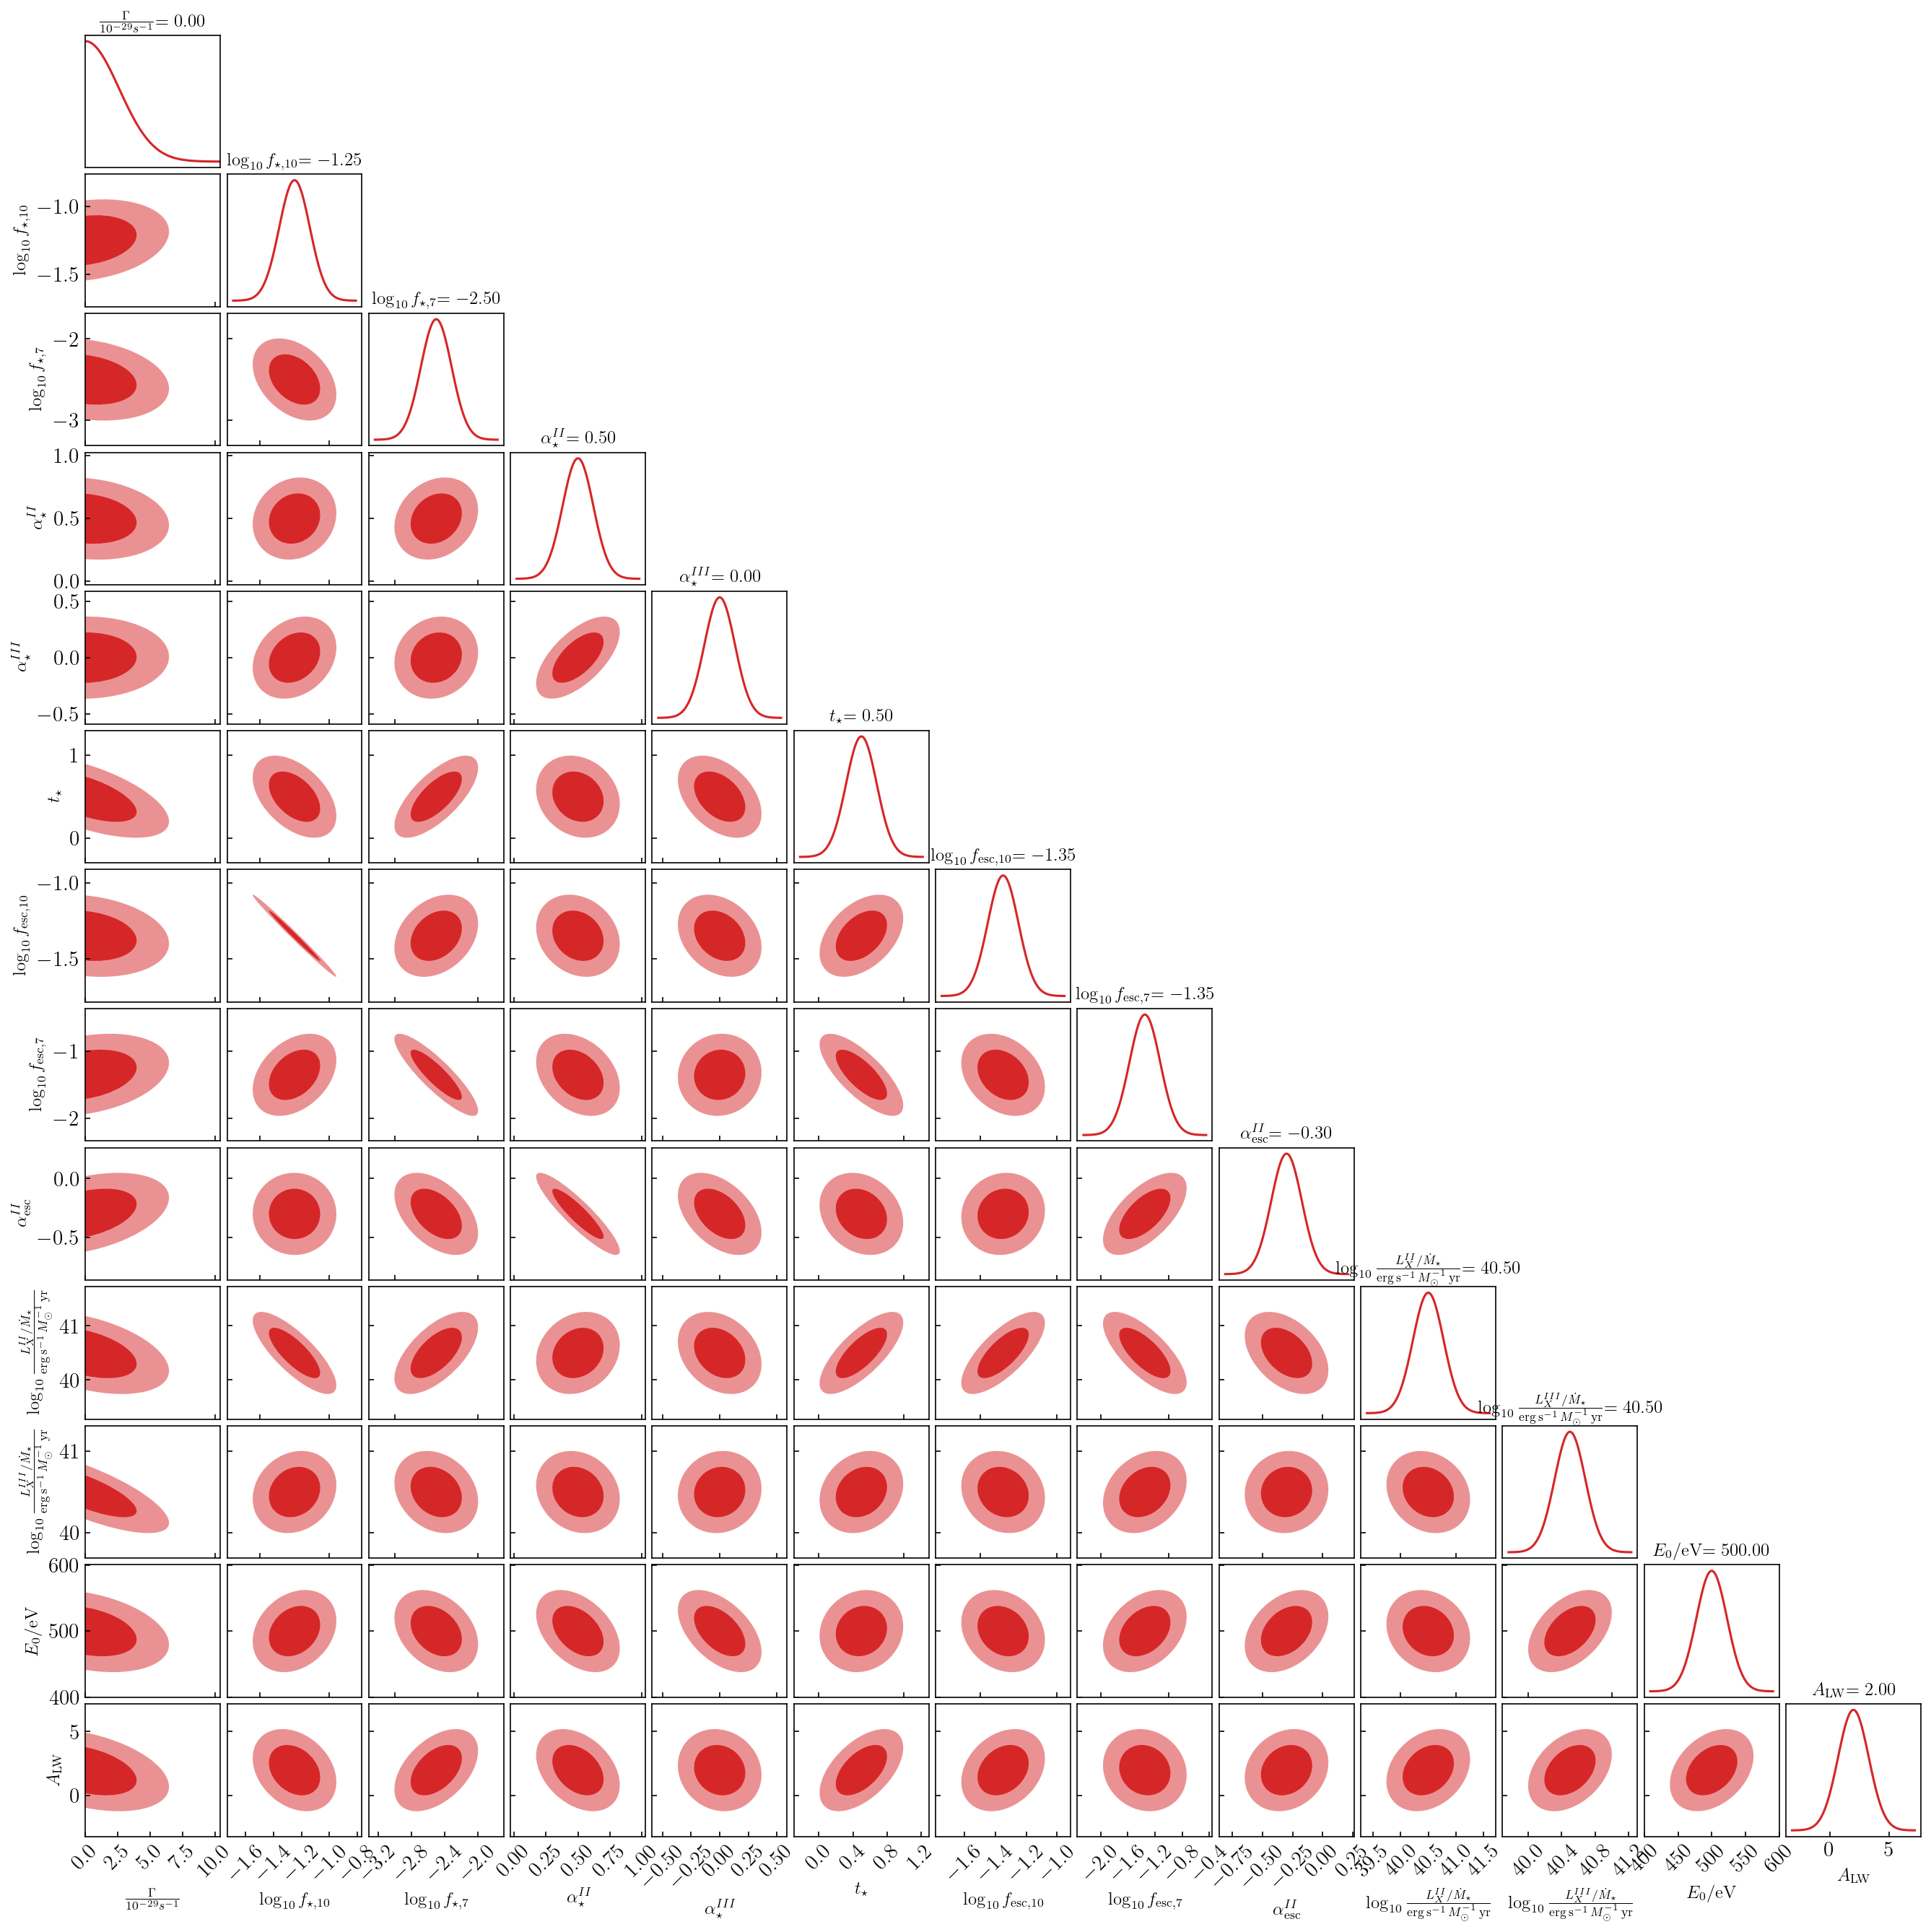

In [34]:
plot_triangle(
    params=astro_params_vary,
    fiducial=fid_params,
    labels=fid_labels,
    cov=F_inv,
    positive_definite=['DM'],
    ellipse_color='C0',
    title_fontsize=12,
    xlabel_kwargs={'labelpad': 5, 'fontsize': 12},
    ylabel_kwargs={'labelpad': 5, 'fontsize': 12},
    fig_kwargs={'figsize': (18, 18)},
    plot1D_kwargs={'c': 'C0', 'lw': 1.5},
);

# Comparison

In [61]:
from scripts.step_size import *

# recommended: 30-100
print(sigma_s)
print(sigma_s * pbhacc_f_base(m_s, 'BHLl2') / pbhacc_f(m_s, 'BHLl2'))

[  0.33495909  20.24147802 290.72630969]
[ 59.56508554 143.29869033  81.93780689]
